# 2D Dispersion measures (grad1 & grad2)

Network dispersion (ND) in 2d gradient space 

* within ND
* between ND: 2sampleTTest & correlations among all combinations(both with multiple ccomparison correction)
* formally test if specific BND (network combination) can explain variance in behavioral measure above group effect


Info
* 1D 
    * parcel space: ND_01.ipynb
    * vertex space: ND_02.ipynb

In [4]:
import numpy as np
import nibabel as nib
from nilearn import datasets
import os.path as op
import os
import pandas as pd
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt

from brainspace.utils.parcellation import map_to_labels, reduce_by_labels
from  nilearn.datasets import fetch_surf_fsaverage
import nilearn.plotting as nplt
import nibabel as nib
import matplotlib.pyplot as plt
import pingouin

bids_folder = '/mnt_03/ds-dnumrisk' 
phenotype_folder = op.join(bids_folder, 'derivatives/phenotype')

subList = [f[4:6] for f in os.listdir(bids_folder) if f[0:4] == 'sub-' and len(f) == 6]

# add group info
df_participants = pd.read_csv(op.join(bids_folder, 'add_tables','subjects_recruit_scan_scanned-final.csv'), header=0) #, index_col=0
group_list = df_participants.loc[:,['subject ID','group','age']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')
group_list = group_list#.reset_index()

# plotting
fsaverage = fetch_surf_fsaverage() # default 5


In [5]:
from utils import get_glasser_parcels, get_glasser_CAatlas_mapping
mask_glasser, labeling_glasser = get_glasser_parcels(space = 'fsaverage5' )
glasser_CAatlas_mapping, CAatlas_names = get_glasser_CAatlas_mapping()

from brainspace.utils.parcellation import map_to_labels
caNets_fsav5_mapping = map_to_labels(glasser_CAatlas_mapping['ca_network'].values , labeling_glasser, mask=mask_glasser) #, fill=np.nan) #grad_sub[n_grad-1]

from utils_02 import get_all_behavior
df_behave = get_all_behavior(bids_folder)

In [6]:
# gradient values, vertex x subject
gms_aligned_g1 = [None] * len(subList)
gms_aligned_g2 = [None] * len(subList)

for i, sub in enumerate(subList):
    source_folder_gm = op.join(bids_folder,'derivatives','gradients',f'sub-{sub}' )
    gm_aligned = np.load(op.join(source_folder_gm,f'sub-{sub}_g-aligned_space-fsaverag5_n10.npy')) # sub-01_g-aligned_space-fsaverag5_n10.npy
    gms_aligned_g1[i] = gm_aligned[0,:] # only one grad to start with
    gms_aligned_g2[i] = gm_aligned[1,:] # only one grad to start with

# to create multidimensional array with all subs, grads & parcels, look at asym_grad....
sub_array= np.array([int(i) for i in subList]) 
n_vertices = np.shape(gms_aligned_g1)[1] # 

In [7]:
g1 = np.array(gms_aligned_g1).T  # n_vertices x n_subjects
g2 = np.array(gms_aligned_g2).T 

N_nets = 12
centroids_net = []  # center of gravity (median) for given network (i.e., network centroid position) (7 x 1000)
WN_dispersion = []  # Within network dispersion: sum squared Euclidean distance of network nodes to the network centroid at individual level (7 x 1000)
for n_network in np.unique(caNets_fsav5_mapping)[1:]:
    
    # Identify the nodes of the given Yeo network
    netNodes = np.where(caNets_fsav5_mapping == (n_network))[0]  # get (Glasser space) indices
    netNodes = np.squeeze(netNodes)
    
    # Get the gradient loadings of the nodes for the given Yeo network, for each subject
    G1_net = g1[netNodes]  # shape: number of nodes in network x N
    G2_net = g2[netNodes]  # shape: number of nodes in network x N
    
    # Stack gradients into a 3D array for easier 2D centroid computation
    G_net = np.stack([G1_net, G2_net], axis=-1)  # shape: number of nodes in network x N x 2
    
    # Compute the centroid (median) for the given Yeo network in 2D for each subject
    centroid_cog_net = np.nanmedian(G_net, axis=0)  # shape: N x 2
    centroids_net.append(centroid_cog_net)
    
    # Compute the 2D Euclidean distance between each node and the centroid for each subject
    dist_nodes_to_centroid = G_net - centroid_cog_net  # shape: number of nodes in network x N x 2
    squared_distances = np.sum(dist_nodes_to_centroid**2, axis=-1)  # sum squares across 2D (last axis), shape: number of nodes in network x N
    
    # Compute the within-network dispersion as the mean squared distance
    mean_squared_distances = np.nanmean(squared_distances, axis=0)  # shape: N
    WN_dispersion.append(mean_squared_distances)

# Convert results to arrays for easier handling
centroids_net = np.array(centroids_net)  # shape: N_nets x N_subs x 2 
WN_dispersion = np.array(WN_dispersion)

## Within Network Dispersion

In [7]:
measure_of_interest =   'Within network dispersion' #  'Network midpoint (centroid)' #

if measure_of_interest == 'Within network dispersion':
    data = WN_dispersion 
elif measure_of_interest == 'Network midpoint (centroid)':
    data = centroids_net
    
df = pd.DataFrame(np.array(data.T), index=sub_array, columns = [f"net_{i+1}" for i in range(N_nets)])
df.index.name = 'subject'
df = df.join(group_list).set_index('group',append=True)

/home/ubuntu/miniconda3/envs/numrefields/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/miniconda3/envs/numrefields/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 12.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


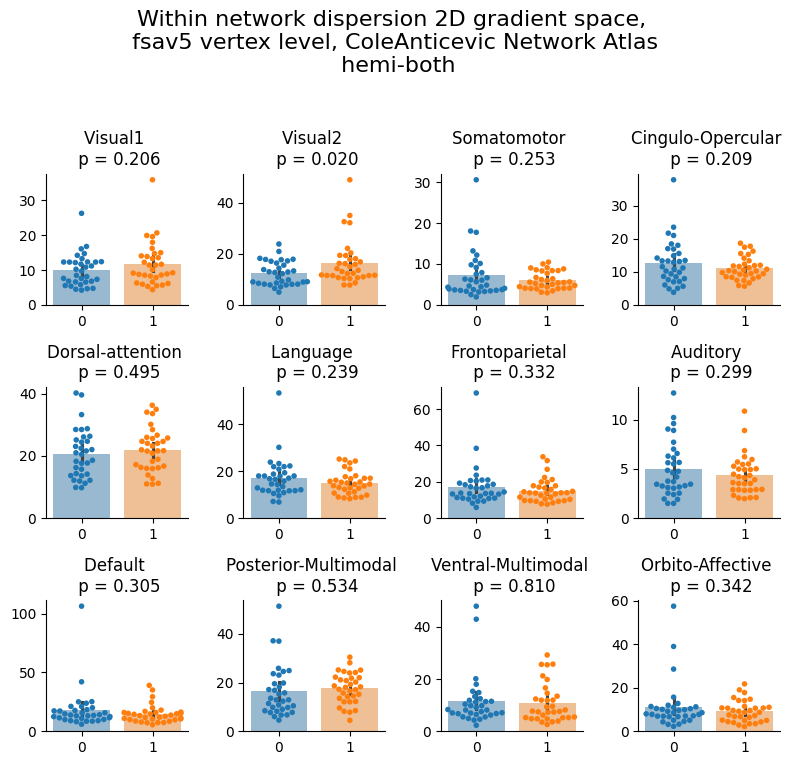

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

network_atlas = 'ColeAnticevic'
network_names = CAatlas_names
hemi = 'both'
#tmp = df.loc[df.abs().mean(axis=1) < 100].reset_index() # remove outlier subjects (weird gradient loading scale due to >1 connected components)
tmp = df.reset_index()

n_cols = 4  # Number of columns in the subplot grid
n_rows = int((N_nets) / n_cols)  # Calculate rows needed for N_nets subplots

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 8)) # , sharex=True, sharey=True
fig.suptitle(f'{measure_of_interest} 2D gradient space, \n fsav5 vertex level, {network_atlas} Network Atlas \n hemi-{hemi}', fontsize=16)

pvals = []
for i in range(N_nets):
    ax = axes[i // n_cols, i % n_cols]  # Calculate position in grid
    net_label_number = (i+1)
    net_name= network_names.loc[net_label_number].item()

    data_net = tmp[f'net_{i + 1}']
    _, p_value = ttest_ind(data_net[tmp['group'] == 0], data_net[tmp['group'] == 1], equal_var=False)  # Welch's t-test
    
    sns.barplot(data=tmp.reset_index(), x ='group', hue='group',y=f'net_{net_label_number}', alpha=0.5,legend=False, ax=ax)
    sns.swarmplot(data=tmp.reset_index(),  x ='group', hue='group',y=f'net_{net_label_number}', size=4,legend=False, ax=ax)

    ax.set_title(f'{net_name} \n p = {p_value:.3f}')
    ax.set_xlabel('')
    ax.set_ylabel('')
    pvals.append(p_value)

sns.despine()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the suptitle
plt.show()

pvals = np.array(pvals)

## Between Network Dispersion/Distances

In [9]:
# 2sample TTests
from scipy.stats import ttest_ind

test_name = '2sample_TTest'

N_nets = 12
mat_pvals = np.ones([N_nets, N_nets])
mat_rs = np.zeros([N_nets, N_nets]) # = Tvals !
mat_outliers = np.zeros([N_nets, N_nets])

distances = []
net_name_comps = []
for n1 in range(N_nets):
    for n2 in range(n1, N_nets):
        #print(n1, n2)
        distance = np.linalg.norm(centroids_net[n1] - centroids_net[n2], axis=1)
        distances.append(distance)

        df = pd.DataFrame(np.array(distance.T), index=sub_array,columns=['net_distance'])
        df.index.name = 'subject'
        df = df.join(group_list['group']).set_index('group',append=True)
        t_stat, p_val = ttest_ind(df.xs(0,0,'group'), df.xs(1,0,'group'), equal_var=False)  # Welch's t-test

        mat_rs[n1,n2] = np.round(t_stat, 3)
        mat_pvals[n1,n2] =  np.round(p_val, 4)

        net_name_comps.append(str(CAatlas_names.loc[n1+1]['Network Name']) +  ' - ' + str(CAatlas_names.loc[n2+1]['Network Name']))


/tmp/ipykernel_3927067/1463250471.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat_rs[n1,n2] = np.round(t_stat, 3)
/tmp/ipykernel_3927067/1463250471.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat_pvals[n1,n2] =  np.round(p_val, 4)
/tmp/ipykernel_3927067/1463250471.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat_rs[n1,n2] = np.round(t_stat, 3)
/tmp/ipykernel_3927067/1463250471.py:25: DeprecationWarning: Conversion of an array with ndim > 0

In [ ]:
# correlation with behavior

y_var = 'skill_score' #'perceptual_noise_sd_unbiased'
x_var = 'net_distance'
test_name = f'Correlation Coefficients of {y_var} with'

N_nets = 12
mat_pvals = np.ones([N_nets, N_nets])
mat_rs = np.zeros([N_nets, N_nets])
mat_outliers = np.zeros([N_nets, N_nets])

distances = []
net_name_comps = []
for n1 in range(N_nets):
    for n2 in range(n1, N_nets):
        print(n1, n2)
        distance = np.linalg.norm(centroids_net[n1] - centroids_net[n2], axis=1)
        distances.append(distance)

        df = pd.DataFrame(np.array(distance.T), index=sub_array,columns=['net_distance'])
        df.index.name = 'subject'
        df_comb = df.join(df_behave).join(group_list).set_index('group',append=True)
        cor = pingouin.corr(df_comb[y_var], df_comb[x_var], method = 'spearman') #defautl: two -sided & pearson 

        mat_rs[n1,n2] = np.round(cor['r'].iloc[0], 2)
        mat_pvals[n1,n2] = np.round(cor['p-val'].iloc[0], 3)

        net_name_comps.append(str(CAatlas_names.loc[n1+1]['Network Name']) +  ' - ' + str(CAatlas_names.loc[n2+1]['Network Name']))


#### Plot results for either 2sTTest or Correlation-behave

Text(0.5, 1.1, '2sample_TTest between network distance \n 2D gradient space, group-all')

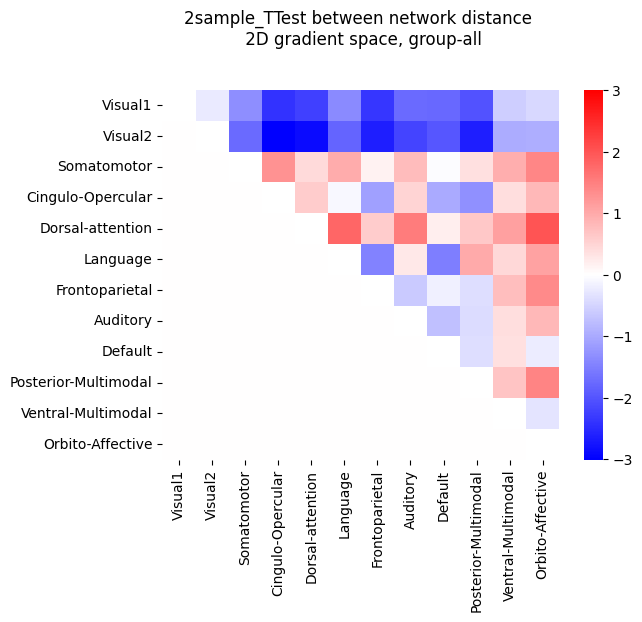

In [10]:
group = 'all'
t_max = np.nanmax(np.abs(mat_rs.flatten())) 
sns.heatmap(mat_rs, cmap='bwr',vmin=-t_max,vmax=t_max,
            xticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)],
            yticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)])
plt.title(f'{test_name} between network distance \n 2D gradient space, group-{group}', y=1.1)

Text(0.5, 1.01, 'P-vals 2sample_TTest  \n Between network distance \n 2D gradient space, group-all')

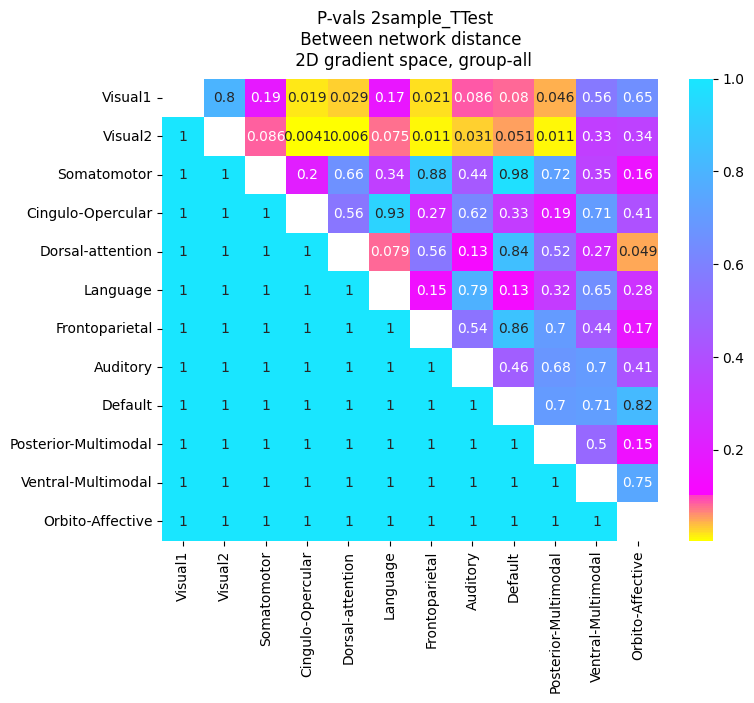

In [11]:
from utils_02 import get_pval_colormap
pval_cmap = get_pval_colormap()

fig, axes = plt.subplots(1,1, figsize=(8,6)) # , sharex=True, sharey=True

sns.heatmap(mat_pvals, cmap=pval_cmap,annot=True,ax=axes, #vmin=-0.4,vmax=0.4,
            xticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)],
            yticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)])
plt.title(f'P-vals {test_name}  \n Between network distance \n 2D gradient space, group-{group}', y=1.01)

In [12]:
pvals = mat_pvals.flatten()
pvals = pvals[pvals != 1]
pvals = [x for x in pvals if not np.isnan(x)]
pvals

# Apply Benjamini-Hochberg FDR correction
from statsmodels.stats.multitest import multipletests
_, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
#print(pvals_corrected)

mask = (mat_pvals != 1) & ~np.isnan(mat_pvals)
corrected_mat_pvals = np.full(mat_pvals.shape, np.nan)
corrected_mat_pvals[mask] = pvals_corrected

In [ ]:
# only multiple comparison over networks contained within NPC mask
network_labels = range(1, 13)
NPC_nets = [ 1,  2,  3,  4,  5,  7,  9, 10]
region_mask = np.isin(network_labels, NPC_nets)  # network_labels should match mat_pvals structure

mask = (mat_pvals != 1) & ~np.isnan(mat_pvals) & region_mask
pvals = mat_pvals[mask]
pvals = pvals[~np.isnan(pvals)]

from statsmodels.stats.multitest import multipletests
_, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')

# Create a new matrix for corrected p-values
corrected_mat_pvals = np.full(mat_pvals.shape, np.nan)
mask = (mat_pvals != 1) & ~np.isnan(mat_pvals) & region_mask
corrected_mat_pvals[mask] = pvals_corrected

Text(0.5, 1.01, 'Corrected  P-vals \n 2sample_TTest - between network distance \n 2D gradient space, group-all')

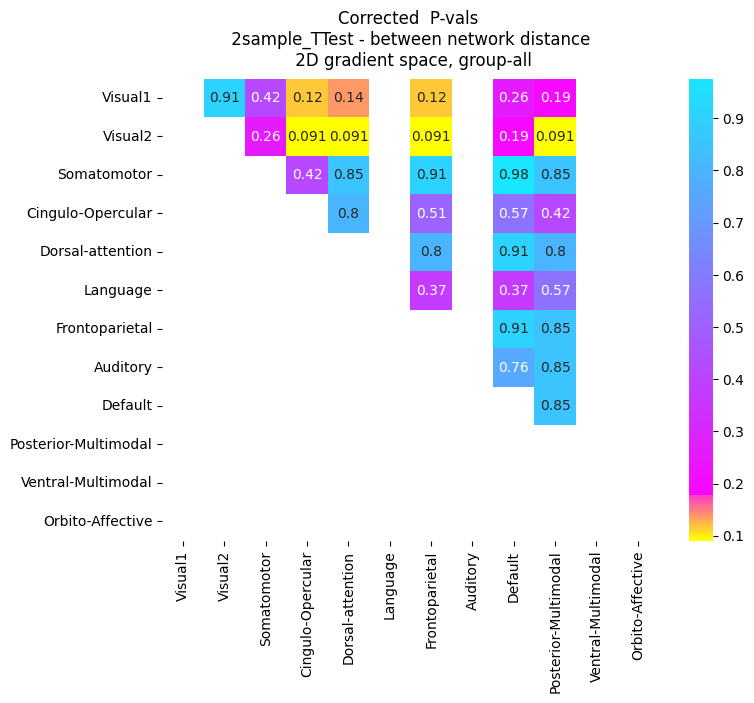

In [19]:
from utils_02 import get_pval_colormap
pval_cmap = get_pval_colormap()

fig, axes = plt.subplots(1,1, figsize=(8,6)) # , sharex=True, sharey=True

sns.heatmap(corrected_mat_pvals, cmap=pval_cmap,annot=True,ax=axes, #vmin=-0.4,vmax=0.4,
            xticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)],
            yticklabels=[str(CAatlas_names.loc[i+1]['Network Name']) for i in range(N_nets)])
plt.title(f'Corrected  P-vals \n {test_name} - between network distance \n 2D gradient space, group-{group}', y=1.01)

## Statistical Model 
Properly test if dispersion measure explains variance above group effect!
(Model from a formula and dataframe.)

In [34]:
df_dist = pd.DataFrame(np.array(distances).T, index=sub_array, columns=net_name_comps)
df_dist.index.name = 'subject'

df_comb = df_dist.join(df_behave).join(group_list['age'])
df_comb.head()

,,Visual1 - Visual1,Visual1 - Visual2,Visual1 - Somatomotor,Visual1 - Cingulo-Opercular,Visual1 - Dorsal-attention,Visual1 - Language,Visual1 - Frontoparietal,Visual1 - Auditory,Visual1 - Default,Visual1 - Posterior-Multimodal,...,basisscore,overall_score,erfassungsspanne,memory_noise_sd_unbiased,perceptual_noise_sd_unbiased,skill_score,visio-spatial IQ,verbal IQ,mean_iq,age
subject,group,,,,,,,,,,,,,,,,,,,,,
1,0,0.0,1.404406,6.941891,4.992864,3.060204,5.733119,7.532277,5.167487,10.500931,2.903470,...,5,13.0,8,0.115213,0.102558,36.0,120.0,105.0,112.5,19.0
2,1,0.0,1.158897,13.822786,10.488104,11.337593,9.135321,10.315224,8.470701,10.646557,6.747210,...,5,10.0,6,0.196658,0.122329,6.0,100.0,95.0,97.5,17.0
3,0,0.0,1.143637,11.977648,6.501068,5.664583,6.064081,7.128536,4.963427,8.700401,3.710826,...,4,7.0,5,0.213540,0.150741,29.0,115.0,95.0,105.0,15.0
4,1,0.0,1.103335,10.070213,7.295241,5.896425,6.491575,9.348876,6.101239,10.798983,5.285868,...,4,7.0,6,0.105920,0.091129,34.0,110.0,105.0,107.5,17.0
5,0,0.0,0.341660,11.725476,6.387669,6.287597,5.127491,5.967499,5.030179,6.562393,3.691107,...,4,10.0,7,0.127888,0.153583,30.0,90.0,115.0,102.5,20.0


In [37]:
x_var = 'skill_score'#'memory_noise_sd' #'perceptual_noise_sd' # 'Percent Correct'# _unbiased 'memory_noise_sd_unbiased ''skill_score'#'
y_var =  'Visual1 - Cingulo-Opercular'# 'Visual2 - Dorsal-attention'#  

#formula1 = 'neuralVar ~ behaveVar + group + age'
formula2 = 'behaveVar ~ neuralVar + group' # + neuralVar:group'

import statsmodels.api as sm

df_comb['neuralVar'] = np.log(df_comb[y_var])
df_comb['behaveVar'] = np.log(df_comb[x_var])

result = sm.formula.ols(formula=formula2, data=df_comb.reset_index()).fit()
print()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              behaveVar   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     16.76
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           4.40e-08
Time:                        11:18:36   Log-Likelihood:                -42.968
No. Observations:                  66   AIC:                             93.94
Df Residuals:                      62   BIC:                             102.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.4115      0.864      5.108      0.000       2.685       6.138
neuralVar          -0.4666      0.421     -1.109      0.272      -1.307       0.374
group               0.7141      1.157      0.617      0.539      -1.599       3.027
neuralVar:group    -0.6402      0.549     -1.167      0.248      -1.737       0.457
==============================================================================
Omnibus:                       24.422   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.195
Skew:                          -1.208   Prob(JB):                     2.08e-11
Kurtosis:                       6.471   Cond. No.                         69.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
# without taking the log of the variables

df_comb['neuralVar'] = df_comb[y_var]
df_comb['behaveVar'] = df_comb[x_var]

result = sm.formula.ols(formula=formula2, data=df_comb.reset_index()).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              behaveVar   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     20.30
Date:                Mon, 27 Jan 2025   Prob (F-statistic):           2.80e-09
Time:                        15:57:04   Log-Likelihood:                -234.58
No. Observations:                  66   AIC:                             477.2
Df Residuals:                      62   BIC:                             485.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.3029      9.183      4.062      0.000      18.946      55.659
neuralVar     -1.5314      0.555     -2.760      0.008      -2.640      -0.422
group        -13.5940      2.244     -6.058      0.000     -18.080      -9.108
age            0.4201      0.394      1.067      0.290      -0.367       1.207
==============================================================================
Omnibus:                        0.275   Durbin-Watson:                   1.534
Prob(Omnibus):                  0.872   Jarque-Bera (JB):                0.402
Skew:                           0.137   Prob(JB):                        0.818
Kurtosis:                       2.734   Cond. No.                         181.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              neuralVar   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     2.621
Date:                Mon, 27 Jan 2025   Prob (F-statistic):             0.0586
Time:                        15:54:12   Log-Likelihood:                0.59585
No. Observations:                  66   AIC:                             6.808
Df Residuals:                      62   BIC:                             15.57
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1003      0.887      2.368      0.021       0.328       3.873
behaveVar      0.1035      0.419      0.247      0.806      -0.734       0.941
group          0.1243      0.195      0.637      0.527      -0.266       0.515
age           -0.0001      0.011     -0.011      0.991      -0.022       0.022
==============================================================================
Omnibus:                        3.235   Durbin-Watson:                   2.229
Prob(Omnibus):                  0.198   Jarque-Bera (JB):                3.027
Skew:                           0.519   Prob(JB):                        0.220
Kurtosis:                       2.848   Cond. No.                         634.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""